## **CHAPTER 4 분류(캐글 산탄데르 고객 만족 예측)**

**산탄데르 고객 만족 예측 분석은 370개의 피처로 주어진 데이터 세트 기반에서 고객 만족 여부를 예측하는 것이다.**

**산탄데르 은행이 캐글에 경연을 의뢰한 데이터로서 피처 이름은 모두 익명 처리돼 이름만을 가지고 어떤 속성인지는 추정할 수 없다.**

**클래스 레이블 명은 Target이며, 이 값이 1이면 불만을 가진 고객, 0이면 만족한 고객이다.**

**모델의 성능 평가는 ROC-AUC(ROC 곡선 영역)로 평가한다. 대부분이 만족이고 불만족인 데이터는 일부일 것이기 때문에 정확한 수치보다는 ROC-AUC가 더 적합하다.**

### **데이터 전처리**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib


C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
# 데이터 불러오기
cust_df= pd.read_csv('./santander-customer-satisfaction/train_santander.csv')

In [4]:
# 76020의 행과 371개의 열로 이루어진 데이터
# 모든 feature가 숫자형이며 null 값은 없다.
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [5]:
cust_df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [8]:
# 레이블인 Target 속성의 값의 분포를 알아본다. 대부분이 만족이며 불만족인 고객은 얼마 되지 않는 4%에 불과하다.
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count() # Target == 1(불만족) 일때 count
total_cnt = cust_df.TARGET.count() # Target의 전체 count
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt/total_cnt))) # 전체 대비 불만족의 비율

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [9]:
# var3 칼럼의 경우 min 값이 -999999이다. NaN이나 특정 예외 값을 -999999으로 변환했을 것이다
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [10]:
print(cust_df.var3.value_counts()[:10]) # -999999가 116개 존재

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64


In [11]:
# var3은 숫자 형이고, 다른 값에 비해 -999999은 너무 편차가 심하므로 -999999를 가장 값이 많은 2로 변환한다.
# 또한 ID 피처는 단순 식별자에 불과하므로 피처를 드롭한다.
# 그리고 클래스 데이터 세트와 피처 데이터 세트를 분리해 별도의 데이터 세트로 별도로 저장한다.
cust_df['var3'].replace(-999999,2,inplace = True)
cust_df.drop('ID', axis=1, inplace=True)

In [12]:
# 피처 세트와 레이블 세트 분리. 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:,:-1] # 맨 마지막 칼럼 전까지
y_labels = cust_df.iloc[:,-1] # 마지막 칼럼만
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_features,y_labels,test_size = 0.2, random_state=0)

In [15]:
train_cnt = y_train.count() # train셋의 전체 데이터의 개수
test_cnt = y_test.count() # test셋의 전체 데이터의 개수
print('학습 세트 shape: {0}, 테스트 세트 shape: {1}'.format(X_train.shape, X_test.shape))

학습 세트 shape: (60816, 369), 테스트 세트 shape: (15204, 369)


In [17]:
# 학습과 테스트 데이터 세트 모두 TARGET의 값의 분포가 원본 데이터와 유사하게 전체 데이터의 4% 정도의 불만족 값(1)로 만들어졌다.
print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt) # 전체 train셋에서 target labels의 비율
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt) # 전체 test셋에서 target labels의 비율

학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


### **XGBoost 모델 학습과 하이퍼 파라미터 튜닝**

**먼저 XGBoost의 학습 모델을 생성하고 예측 결과를 ROC AUC로 평가해 본다. 사이킷런 래퍼인 XGBClassifier를 기반으로 학습을 수행한다.**

> **estimators는 200으로 하되 early_stopping_rounds를 50으로 설정**

> **성능 평가 기준이 ROC-AUC이므로 XGBClassifier가 eval_metric은 auc로한다.(logloss로 해도 큰 차이는 없다.)**

> **그리고 평가 데이터 세트는 앞에서 분리한 테스트 데이터 세트를 이용한다.**

**사실 테스트 데이터 세트를 XGBoost의 평가 데이터 세트로 사용하면 과적합의 가능성을 증가시킬 수 있지만, 여기서는 이러한 점만 주지하고 넘어간다.**

In [21]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [22]:
# n_estimator = 500, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

In [23]:
# 성능 평가 지표로 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
           eval_metric='auc',eval_set=[(X_train,y_train),(X_test,y_test)])

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=500, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=156, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [24]:
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

ROC AUC: 0.8419


**다음으로는 XGBoost의 하이퍼 파라미터 튜닝을 수행한다.**

**칼럼의 개수가 많으므로 과적합 가능성을 가정하고, max_depth, min_child_weight, colsample_bytree 하이퍼 파라미터만 일차 튜닝 대상으로 한다.**

> **학습 시간이 많이 필요한 ML 모델인 경우 하이퍼 파라미터 튜닝을 수행하는 요령 중 첫 번째는 먼저 2~3개 정도의 파라미터를 결합해 최적 파라미터를 찾아낸 뒤에 이 최적 파라미터를 기반으로 다시 1 ~ 2개 파라미터를 결합해 파라미터 튜닝을 수행하는 것이다.**

In [27]:
# 다음 예제 코드는 8개의 하이퍼 파라미터 경우의 수를 가진다.
# 수행시간이 오래 걸리므로 n_estimator는 100으로 줄이고, early_stopping_rounds도 30으로 줄여서 테스트한 뒤
# 파라미터 튜닝이 완료되면 다시 증가
# 또한 수행 시간을 줄이기 위해서 GridSearchCV의 cv 파라미터를 설정하지 않는다. 즉, 하이퍼 파라미터만 번갈아가면서 평가
# "서브 샘플"은 각 트리를 훈련하는 데 사용될 훈련 샘플 (임의로 선택)의 일부입니다.
# "colsample_by_tree"는 각 트리를 훈련시키는 데 사용될 기능의 일부 (임의로 선택됨)입니다.
# "colsample_bylevel"은 각 노드에서 각 트리를 학습하는 데 사용할 기능의 일부 (임의로 선택됨)입니다.

from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5,7],'min_child_weight':[1,3],'colsample_bytree':[0.5,0.75]}

# 하이퍼 파라미터 테스트의 수행속도를 향상시키기 위해 cv를 지정하지 않음
gridcv = GridSearchCV(xgb_clf,param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric = 'auc',
          eval_set = [(X_train,y_train),(X_test,y_test)])

print('GridSearchCV 최적 파라미터:',gridcv.best_params_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[0]	validation_0-auc:0.791606	validation_1-auc:0.793207
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.810549	validation_1-auc:0.807917
[2]	validation_0-auc:0.819773	validation_1-auc:0.816165
[3]	validation_0-auc:0.821963	validation_1-auc:0.820045
[4]	validation_0-auc:0.826335	validation_1-auc:0.82269
[5]	validation_0-auc:0.830478	validation_1-auc:0.830567
[6]	validation_0-auc:0.825077	validation_1-auc:0.825696
[7]	validation_0-auc:0.829104	validation_1-auc:0.827806
[8]	validation_0-auc:0.831989	validation_1-auc:0.829475
[9]	validation_0-auc:0.827896	validation_1-auc:0.826348
[10]	validation_0-auc:0.825011	validation_1-auc:0.823719
[11]	validation_0-auc:0.823489	validation_1-auc:0.821577
[12]	validation_0-auc:0.828526	validation_1-auc:0.826595
[13]	validation_0-auc:0.833514	validation_1-auc:0.830411
[14]	validation_0-auc:0.835148	validation_1-auc:0.831457

In [28]:
xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {:.4f}'.format(xgb_roc_score))

ROC AUC: 0.8449


**이전 예제의 ROC-AUC가 약 0.8419 -> 0.8438로 조금 개선되었다. 물론 시간을 추자한 것만큼은 아닐 수 있으나 캐글과 같이 치열한 순위 경쟁이 필요한 경우 이 정도의 수치 개선은 도움이 될 수 있다.** 

**앞에서 구한 최적화 하이퍼 파라미터를 기반으로 다른 하이퍼 파라미터를 변경 또는 추가해 다시 최적화를 진행한다.**

> **위에서 나온 결과에서 n_estimator=1000으로 증가시키고, learning_rate는 0.02로 감소시킨다. 그리고 reg_alpha=0.03을 추가**

In [29]:
# n_estimator=1000, learning_rate=0.02, reg_alpha=0.03

xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=5,
                       min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

In [30]:
# 성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정하고 학습 수행

xgb_clf.fit(X_train, y_train, early_stopping_rounds=200,
           eval_metric='auc',eval_set = [(X_train,y_train),(X_test,y_test)])

[0]	validation_0-auc:0.710266	validation_1-auc:0.718502
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.804679	validation_1-auc:0.805449
[2]	validation_0-auc:0.799198	validation_1-auc:0.794525
[3]	validation_0-auc:0.800034	validation_1-auc:0.795415
[4]	validation_0-auc:0.805393	validation_1-auc:0.798995
[5]	validation_0-auc:0.815965	validation_1-auc:0.811068
[6]	validation_0-auc:0.823301	validation_1-auc:0.818172
[7]	validation_0-auc:0.826112	validation_1-auc:0.8217
[8]	validation_0-auc:0.829149	validation_1-auc:0.824573
[9]	validation_0-auc:0.828324	validation_1-auc:0.823395
[10]	validation_0-auc:0.829604	validation_1-auc:0.824198
[11]	validation_0-auc:0.82942	validation_1-auc:0.82473
[12]	validation_0-auc:0.831162	validation_1-auc:0.825752
[13]	validation_0-auc:0.828767	validation_1-auc:0.824629
[14]	validation_0-auc:0.83088	validation_1-auc:0.826452
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.75, gamma=0,
       learning_rate=0.02, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=156,
       reg_alpha=0.03, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [32]:
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {:.4f}'.format(xgb_roc_score))

ROC AUC: 0.8439


**이전에도 설명했지만 XGBoost가 GBM보다는 빠르지만 아무래도 GBM을 기반으로 하고 있기 때문에 수행 시간이 상당히 더 많이 요구 된다는 점이다.**

**그 때문에 하이퍼 파라미터를 다양하게 나열해 파라미터를 튜닝하는 것은 많은 시간이 소모된다.**

**앙상블 계열 알고리즘에서 하이퍼 파라미터 튜닝으로 성능 수치 개선이 급격하게 되는 경우는 많지 않다.**

> **앙상블 계열 알고리즘은 과적합이나 잡음에 기본적으로 뛰어난 알고리즘이기 때문이다.**

>**일반 pc가 아닌 적어도 8코어 이상의 병렬 CPU 코어 시스템을 가진 컴퓨터가 있다면 더 다양하게 성능 향상을 시도해볼 수 있다.**

In [33]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

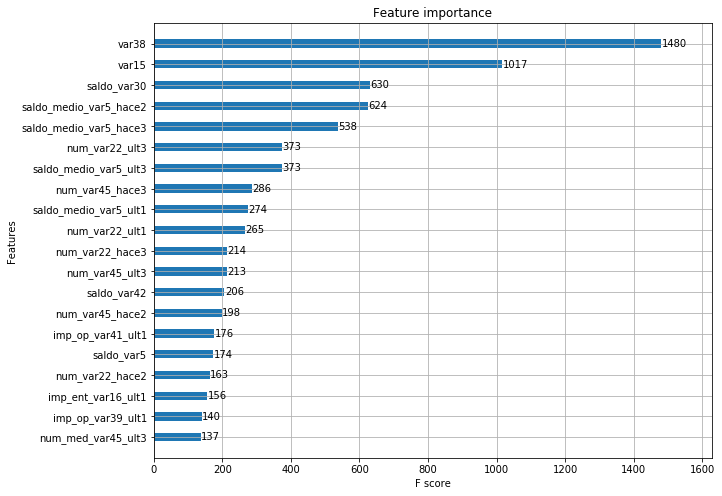

In [35]:
# XGBoost의 예측 성능을 좌우하는 가장 중요한 피처는 var38, var15이다
fit, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf,ax=ax,max_num_features=20,height=0.4)

### **LightGBM 모델 학습과 하이퍼 파라미터 튜닝**

**앞의 XGBoost에서 불러온 데이터 세트를 기반으로 LightGBM을 수행하고, ROC-AUC를 측정**

**앞의 XGBoost 예제와 동일하게 n_estimators는 500으로 설정하고, early_stopping_rounds는 100, 평가 데이터 세트는 테스트 데이터 세트, eval_metric은 auc로 설정한다.**

In [36]:
from lightgbm import LGBMClassifier

In [38]:
# 모델 불러오기
lgbm_clf = LGBMClassifier(n_estimators=500)
evals = [(X_test,y_test)]

In [39]:
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=evals, verbose=True)

[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.81863	valid_0's binary_logloss: 0.16
[3]	valid_0's auc: 0.827411	valid_0's binary_logloss: 0.156287
[4]	valid_0's auc: 0.832175	valid_0's binary_logloss: 0.153416
[5]	valid_0's auc: 0.83481	valid_0's binary_logloss: 0.151206
[6]	valid_0's auc: 0.834721	valid_0's binary_logloss: 0.149303
[7]	valid_0's auc: 0.83659	valid_0's binary_logloss: 0.147804
[8]	valid_0's auc: 0.837602	valid_0's binary_logloss: 0.146466
[9]	valid_0's auc: 0.838114	valid_0's binary_logloss: 0.145476
[10]	valid_0's auc: 0.838472	valid_0's binary_logloss: 0.144681
[11]	valid_0's auc: 0.83808	valid_0's binary_logloss: 0.143978
[12]	valid_0's auc: 0.837771	valid_0's binary_logloss: 0.14341
[13]	valid_0's auc: 0.838063	valid_0's binary_logloss: 0.142835
[14]	valid_0's auc: 0.838485	valid_0's binary_logloss: 0.142296
[15]	valid_0's auc: 0.838542	valid_0's binary_logloss: 0.14

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [40]:
lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {:.4f}'.format(lgbm_roc_score))

ROC AUC: 0.8396


**LightGBM을 직접 수행해 보면 XGBoost보다 학습에 걸리는 시간이 좀 더 단축됐음을 느낄 수 있다.**

In [41]:
from sklearn.model_selection import GridSearchCV

In [42]:
# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
LGBM_clf = LGBMClassifier(n_estimators=200)

In [43]:
params = {
    'num_leaves':[32, 64],
    'max_depth': [128, 160],
    'min_child_samples': [60,100],
    'subsample': [0.8,1]
}

In [46]:
# 하이퍼 파라미터 테스트의 수행속도를 향상시키기 위해 cv를 지정하지 않는다.
gridcv = GridSearchCV(lgbm_clf,param_grid=params)
gridcv.fit(X_train,y_train,early_stopping_rounds=30,eval_metric='auc',
          eval_set = [(X_train,y_train),(X_test,y_test)])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164998
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.825775	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821831	valid_1's binary_logloss: 0.15988
[3]	valid_0's auc: 0.832192	valid_0's binary_logloss: 0.147167	valid_1's auc: 0.827302	valid_1's binary_logloss: 0.156397
[4]	valid_0's auc: 0.837518	valid_0's binary_logloss: 0.144131	valid_1's auc: 0.8334	valid_1's binary_logloss: 0.153325
[5]	valid_0's auc: 0.842289	valid_0's binary_logloss: 0.141651	valid_1's auc: 0.836018	valid_1's binary_logloss: 0.150959
[6]	valid_0's auc: 0.844974	valid_0's binary_logloss: 0.139661	valid_1's auc: 0.838022	valid_1's binary_logloss: 0.149046
[7]	valid_0's auc: 0.846623	valid_0's binary_logloss: 0.138001	valid_1's auc: 0.837777	valid_1's binary_logloss: 0.147509
[8]	valid_0's auc: 0.848529	valid_0's binary_logloss: 0.136578	valid_1's auc: 0.839519	v

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'num_leaves': [32, 64], 'max_depth': [128, 160], 'min_child_samples': [60, 100], 'subsample': [0.8, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [48]:
print('GridSearchCV 최적 파라미터:',gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {:.4f}'.format(lgbm_roc_score))

GridSearchCV 최적 파라미터: {'max_depth': 128, 'min_child_samples': 100, 'num_leaves': 32, 'subsample': 0.8}
ROC AUC: 0.8442


In [49]:
# 해당 하이퍼 파라미터를 LightGBM에 적용하고 다시 학습해 ROC-AUC 측정 결과를 도출해본다
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, subsample=0.8, min_child_samples=100, max_depth=128)
evals = [(X_test,y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'auc', eval_set = evals, verbose=True)

[1]	valid_0's auc: 0.819488	valid_0's binary_logloss: 0.165016
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.822387	valid_0's binary_logloss: 0.159711
[3]	valid_0's auc: 0.829542	valid_0's binary_logloss: 0.156068
[4]	valid_0's auc: 0.834917	valid_0's binary_logloss: 0.153141
[5]	valid_0's auc: 0.837871	valid_0's binary_logloss: 0.150804
[6]	valid_0's auc: 0.839548	valid_0's binary_logloss: 0.148876
[7]	valid_0's auc: 0.841812	valid_0's binary_logloss: 0.147225
[8]	valid_0's auc: 0.842382	valid_0's binary_logloss: 0.14594
[9]	valid_0's auc: 0.842811	valid_0's binary_logloss: 0.144866
[10]	valid_0's auc: 0.843186	valid_0's binary_logloss: 0.143872
[11]	valid_0's auc: 0.843465	valid_0's binary_logloss: 0.14305
[12]	valid_0's auc: 0.843222	valid_0's binary_logloss: 0.142376
[13]	valid_0's auc: 0.843564	valid_0's binary_logloss: 0.141783
[14]	valid_0's auc: 0.843389	valid_0's binary_logloss: 0.141419
[15]	valid_0's auc: 0.84365	valid_0's binary_logloss

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=128,
        min_child_samples=100, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=1000, n_jobs=-1, num_leaves=32, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [50]:
lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {:.4f}'.format(lgbm_roc_score))

ROC AUC: 0.8442
